In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine
from spatial_maps.fields import (
    find_peaks, calculate_field_centers, separate_fields_by_laplace, 
    map_pass_to_unit_circle, calculate_field_centers, distance_to_edge_function, 
    which_field, compute_crossings)
from phase_precession import cl_corr
from spike_statistics.core import permutation_resampling_test
import matplotlib.mlab as mlab
import scipy.signal as ss
from scipy.interpolate import interp1d
from septum_mec.analysis.plotting import regplot
from skimage import measure
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# %matplotlib notebook
%matplotlib inline

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "phase-precession"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [5]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


# divide into stim not stim

In [6]:
data['group'] = np.nan

In [7]:
############################ Only true baseline (preceeding stim)  #############################
data.loc[data.eval('baseline and i and Hz11 and gridcell'), 'group'] = 'baseline_i'
data.loc[data.eval('stimulated and frequency==11 and stim_location=="ms" and gridcell'), 'group'] = 'stim_11'

data.loc[data.eval('baseline and ii and Hz30 and gridcell'), 'group'] = 'baseline_ii'
data.loc[data.eval('stimulated and frequency==30 and stim_location=="ms" and gridcell'), 'group'] = 'stim_30'


################################## All baseline sessions #######################################
# data.loc[data.eval('baseline and i'), 'group'] = 'baseline_i'
# data.loc[data.eval('stimulated and frequency==11 and stim_location=="ms"'), 'group'] = 'stim_11'

# data.loc[data.eval('baseline and ii'), 'group'] = 'baseline_ii'
# data.loc[data.eval('stimulated and frequency==30 and stim_location=="ms"'), 'group'] = 'stim_30'

In [8]:
data.groupby('group').count().action

group
baseline_i     66
baseline_ii    51
stim_11        61
stim_30        40
Name: action, dtype: int64

# Plotting

In [9]:
max_speed = .5 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

speed_binsize = 0.02

stim_mask = True
baseline_duration = 600

In [10]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, 
    stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [11]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [12]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def remove_artifacts(anas, spikes=None, width=500, threshold=2, sampling_rate=None, fillval=0):
    sampling_rate = sampling_rate or anas.sampling_rate.magnitude
    times = np.arange(anas.shape[0]) / sampling_rate
    anas = np.array(anas)
    if anas.ndim == 1:
        anas = np.reshape(anas, (anas.size, 1))
    assert len(times) == anas.shape[0]
    nchan = anas.shape[1]
    if spikes is not None:
        spikes = np.array(spikes)
    for ch in range(nchan):
        idxs, = np.where(abs(anas[:, ch]) > threshold)
        for idx in idxs:
            if spikes is not None:
                t0 = times[idx-width]
                stop = idx+width
                if stop > len(times) - 1:
                    stop = len(times) - 1 
                t1 = times[stop]
                mask = (spikes > t0) & (spikes < t1)
                spikes = spikes[~mask]
            anas[idx-width:idx+width, ch] = fillval
    if spikes is not None:
        spikes = spikes[spikes <= times[-1]]
        return anas, times, spikes
    else:
        return anas, times

In [13]:
def find_theta_peak(p, f, f1, f2):
    if np.all(np.isnan(p)):
        return np.nan, np.nan
    mask = (f > f1) & (f < f2)
    p_m = p[mask]
    f_m = f[mask]
    peaks = find_peaks(p_m)
    idx = np.argmax(p_m[peaks])
    return f_m[peaks[idx]], p_m[peaks[idx]]

In [29]:
def compute_spike_phase(lfp, times, return_degrees=False):
    from scipy.fftpack import next_fast_len
    x_a = scipy.signal.hilbert(
        lfp, next_fast_len(len(lfp)))[:len(lfp)]
#     x_a = hilbert(lfp)
    x_phase = np.angle(x_a, deg=return_degrees)
    return interp1d(times, x_phase)

In [15]:
def find_grid_fields(rate_map, sigma=3, seed=2.5):
    # find fields with laplace
    fields_laplace = sp.fields.separate_fields_by_dilation(rate_map, sigma=sigma, seed=seed)
    fields = fields_laplace.copy() # to be cleaned by Ismakov
    fields_areas = scipy.ndimage.measurements.sum(
        np.ones_like(fields), fields, index=np.arange(fields.max() + 1))
    fields_area = fields_areas[fields]
    fields[fields_area < 9.0] = 0

    # find fields with Ismakov-method
    fields_ismakov, radius = sp.separate_fields_by_distance(rate_map)
    fields_ismakov_real = fields_ismakov * bin_size
    approved_fields = []

    # remove fields not found by both methods
    for point in fields_ismakov:
        field_id = fields[tuple(point)]
        approved_fields.append(field_id)

    for field_id in np.arange(1, fields.max() + 1):
        if not field_id in approved_fields:
            fields[fields == field_id] = 0
            
    return fields

In [16]:
def normalize(a):
    _a = a - a.min()
    return _a / _a.max()

In [17]:
def distance(x, y):
    _x = x - x.min()
    _y = y - y.min()
    dx, dy = np.diff(_x), np.diff(_y)
    s = np.sqrt(dx**2 + dy**2)
    distance = np.cumsum(s) 
    # first index is distance from first point, 
    # to match len(x) we put a zero as first index to initialize distance 0
    return np.concatenate(([0], distance))

In [18]:
def model(x, slope, phi0):
    return 2 * np.pi * slope * x + phi0

In [19]:
def inspect_lfp(row, flim=[6,10], threshold=2):
    lfp = data_loader.lfp(row.action, row.channel_group)
    spikes = data_loader.spike_train(row.action, row.channel_group, row.unit_name)
    cleaned_lfp_, times_ = remove_artifacts(lfp, threshold=threshold)
    peak_amp = {}
    for i, ch in enumerate(cleaned_lfp_.T):
        pxx, freqs = mlab.psd(ch, Fs=lfp.sampling_rate.magnitude, NFFT=4000)
        f, p = find_theta_peak(pxx, freqs, *flim)
        peak_amp[i] = p

    theta_channel = max(peak_amp, key=lambda x: peak_amp[x])
    
    cleaned_lfp, times, cleaned_spikes = remove_artifacts(
        lfp.magnitude[:,theta_channel], spikes, threshold=threshold, sampling_rate=lfp.sampling_rate.magnitude, fillval=0)
    cleaned_lfp = cleaned_lfp.ravel()
#     filtered_lfp = butter_bandpass_filter(
#         lfp.magnitude[:,theta_channel], *flim, fs=lfp.sampling_rate.magnitude, order=3)
    filtered_lfp = butter_bandpass_filter(
        cleaned_lfp, *flim, fs=lfp.sampling_rate.magnitude, order=3)
    
#     cleaned_lfp, times, cleaned_spikes = remove_artifacts(
#         filtered_lfp, spikes, threshold=threshold, sampling_rate=lfp.sampling_rate.magnitude, fillval=0)
    
    
    
    return cleaned_lfp, filtered_lfp, lfp.magnitude[:,theta_channel]

In [20]:
# cleaned_lfp, filtered_lfp, raw_lfp = inspect_lfp(data.query('action=="1833-260619-1" and unit_idnum==32').iloc[0])

In [21]:
# plt.plot(raw_lfp, label='raw')
# plt.plot(cleaned_lfp, label='cleaned')
# plt.plot(filtered_lfp, label='filtered')
# plt.legend()
# plt.xlim(36000, 42000)

In [22]:
# def compute_data(row, flim=[6,10], threshold=2):
#     lfp = data_loader.lfp(row.action, row.channel_group)
#     spikes = data_loader.spike_train(row.action, row.channel_group, row.unit_name)
#     rate_map = data_loader.rate_map(row.action, row.channel_group, row.unit_name, smoothing=0.04)
#     pos_x, pos_y, pos_t, pos_speed = map(data_loader.tracking(row.action).get, ['x', 'y', 't', 'v'])
#     sample_rate = lfp.sampling_rate.magnitude
    
#     # to select the best LFP channel
#     cleaned_lfp_, _ = remove_artifacts(lfp, threshold=threshold)
#     peak_amp = {}
#     for i, ch in enumerate(cleaned_lfp_.T):
#         pxx, freqs = mlab.psd(ch, Fs=sample_rate, NFFT=4000)
#         f, p = find_theta_peak(pxx, freqs, *flim)
#         peak_amp[i] = p
#     theta_channel = max(peak_amp, key=lambda x: peak_amp[x])
    
#     # sometimes the position is recorded after LFP recording is ended
#     times = np.arange(lfp.shape[0]) / sample_rate
#     idxs_to_remove, = np.where(pos_t > times[-1])
#     pos_x = np.delete(pos_x, idxs_to_remove)
#     pos_y = np.delete(pos_y, idxs_to_remove)
#     pos_t = np.delete(pos_t, idxs_to_remove)
    
    
#     filtered_lfp = butter_bandpass_filter(
#         lfp.magnitude[:,theta_channel], *flim, fs=sample_rate, order=3)

#     spike_phase_func = compute_spike_phase(filtered_lfp, times)
    
#     fields = find_grid_fields(rate_map, sigma=2.5, seed=2.5)
    
#     return spike_phase_func, spikes, pos_x, pos_y, pos_t, rate_map, fields

def compute_data(row, flim=[6,10]):
    lfp = data_loader.lfp(row.action, row.channel_group)
    spikes = data_loader.spike_train(row.action, row.channel_group, row.unit_name)
    rate_map = data_loader.rate_map(row.action, row.channel_group, row.unit_name, smoothing=0.04)
    pos_x, pos_y, pos_t, pos_speed = map(data_loader.tracking(row.action).get, ['x', 'y', 't', 'v'])
    
    sample_rate = lfp.sampling_rate.magnitude

    cleaned_lfp_, times_ = remove_artifacts(lfp)
    peak_amp = {}
    for i, ch in enumerate(cleaned_lfp_.T):
        pxx, freqs = mlab.psd(ch, Fs=sample_rate, NFFT=4000)
        f, p = find_theta_peak(pxx, freqs, *flim)
        peak_amp[i] = p

    theta_channel = max(peak_amp, key=lambda x: peak_amp[x])
    
    # sometimes the position is recorded after LFP recording is ended
    times = np.arange(lfp.shape[0]) / sample_rate
    
    idxs_to_remove, = np.where(pos_t > times[-1])
    pos_x = np.delete(pos_x, idxs_to_remove)
    pos_y = np.delete(pos_y, idxs_to_remove)
    pos_t = np.delete(pos_t, idxs_to_remove)
    
    spikes = np.array(spikes)
    spikes = spikes[(spikes > pos_t.min()) & (spikes < pos_t.max())]
    
    filtered_lfp = butter_bandpass_filter(
        lfp.magnitude[:,theta_channel], *flim, fs=sample_rate, order=3)
    
    # only relevant for 1849?
    cleaned_lfp, times, cleaned_spikes = remove_artifacts(
        filtered_lfp, spikes, threshold=2, sampling_rate=sample_rate, fillval=0)
    
    cleaned_lfp = cleaned_lfp.ravel()

    spike_phase_func = compute_spike_phase(cleaned_lfp, times)
    
    fields = find_grid_fields(rate_map, sigma=2.5, seed=2.5)
    
    return spike_phase_func, spikes, pos_x, pos_y, pos_t, rate_map, fields

In [148]:
def plot_spikes_and_rate_map(row, rate_map, fields, pos_x, pos_y, sy, sx, spikes, box_size, bin_size, dot_size, flim, output_path, save, axs):
    contours = measure.find_contours(fields, 0.8)

    # Display the image and plot all contours found
    axs[1][0].imshow(rate_map.T, extent=[0, box_size[0], 0, box_size[1]], origin='lower')
    axs[1][1].plot(pos_x, pos_y, color='k', alpha=.2, zorder=1000)
    axs[1][1].scatter(sx(spikes), sy(spikes), s=dot_size, zorder=10001, color='r')

    for ax in axs.ravel()[1:]:
        for n, contour in enumerate(contours):
            ax.plot(contour[:, 0] * bin_size, contour[:, 1] * bin_size, linewidth=2)

    for ax in axs.ravel()[1:]:
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        
#         axs[0][0].set_aspect(1 / (4*np.pi))

    despine()
        
def plot_spike_phase(spike_dist, spike_phase, dot_size, slope, phi0, circ_lin_corr, pval, RR, plot_regression_line, ax, plot_title):
    p = ax.scatter(
        spike_dist, spike_phase, s=dot_size, 
        facecolor='k', edgecolor='k', marker='o')
    ax.scatter(
        spike_dist, spike_phase + 2 * np.pi, s=dot_size, 
        facecolor=p.get_facecolor()[0], edgecolor=p.get_edgecolor()[0], marker='o')
    ax.set_yticks([-np.pi, np.pi, 3*np.pi])
    ax.set_yticklabels([r'$-\pi$', r'$\pi$', r'$3\pi$'])
    if plot_regression_line:
        line_fit = model(spike_dist, slope, phi0)
        ax.plot(spike_dist, line_fit, lw=2, color='grey')
    ax.set_aspect(1 / (4 * np.pi))
        
def compute_rate_crossings(spikes, times, threshold=0):
    from elephant.statistics import instantaneous_rate
    from elephant.kernels import GaussianKernel
    import quantities as pq
    import neo
    spikes = neo.SpikeTrain(spikes, t_stop=times[-1], units='s')
    
    kernel = GaussianKernel(100 * pq.ms)
    
    rate = instantaneous_rate(spikes, np.diff(times).min() * pq.s, kernel=kernel)
    
    rate = rate.magnitude
    mean = np.mean(rate)
    std = np.std(rate)
    indices = np.where(rate > mean + std * threshold)[0]
    
    field_indices = np.concatenate(([0], indices.astype(int), [0]))
    enter, = np.where(np.diff(field_indices) > 1)
    exit = enter[1:] - 1
    return rate, indices, indices[enter], indices[exit]

In [24]:
def compute_phase_precession_runs(row, flim=[6, 10], field_num=None, slope_limit_dist=[-1,1], slope_limit_dur=[-1,1], norm=False, store_runs=False,
                             plot=False, plot_regression_line=True, save=False, dot_size=1, crossing_type='field', plot_title=True):
    '''
    flim : [flow, fhigh]
    field_num : int
        which field to plot
    reg_limit : [low, high]
        Regression intervall
    plot : str
        "all" or "scatter"
    plot_regression_line : bool
        plot the regression line in scatter
    save : bool
        save plot
    dot_size : size of scatter dots
    '''
    if plot == 'all':
        fig, axs = plt.subplots(2, 2)
        plt.suptitle(f'{row.action} {row.channel_group} {row.unit_idnum}')
    elif plot == 'scatter':
        fig, ax = plt.subplots(1, 1)
        axs = [[ax]]
        ax.set_title(f'{row.action} {row.channel_group} {row.unit_idnum}')
        
    spike_phase_func, spikes, pos_x, pos_y, pos_t, rate_map, fields = compute_data(
        row, flim)
    
    if field_num is not None:
        fields = np.where(fields == field_num, fields, 0)
        
    if crossing_type == 'field':
        in_field_indices = which_field(pos_x, pos_y, fields, box_size)
        in_field_enter, in_field_exit = compute_crossings(in_field_indices)
    elif crossing_type == 'rate':
        _, _, in_field_enter, in_field_exit = compute_rate_crossings(spikes, pos_t)

    spikes = np.array(spikes)
    spikes = spikes[(spikes > pos_t.min()) & (spikes < pos_t.max())]

    sx, sy = interp1d(pos_t, pos_x), interp1d(pos_t, pos_y)
    results = []
    max_dist = 0
    for en, ex in zip(in_field_enter, in_field_exit):
        x, y, t = pos_x[en:ex+1], pos_y[en:ex+1], pos_t[en:ex+1]
        if len(t) <= 1:
            continue
        s = spikes[(spikes > t[0]) & (spikes < t[-1])]
        if len(s) < 5:
            continue

        spike_phase = spike_phase_func(s)
        
        dist = distance(x, y)
        if norm:
            t_to_dist = interp1d(t, normalize(dist))
        else:
            t_to_dist = interp1d(t, dist)
            
        spike_dist = t_to_dist(s)
        spike_dur = s - t[0]
        
        circ_lin_corr_dist, pval_dist, slope_dist, phi0_dist, RR_dist = cl_corr(
            spike_dist, spike_phase, *slope_limit_dist, return_pval=True)
        circ_lin_corr_dur, pval_dur, slope_dur, phi0_dur, RR_dur = cl_corr(
            spike_dur, spike_phase, *slope_limit_dur, return_pval=True)
        result_run = {
            'action': row.action, 
            'channel_group': row.channel_group, 
            'unit_name': row.unit_name,
            'group': row.group,
            'unit_idnum': row.unit_idnum,
            'slope_limit_dist': slope_limit_dist,
            'slope_limit_dur': slope_limit_dur,
            'flim': flim,
            'crossing_type': crossing_type,
            'norm': norm,
            'circ_lin_corr_dist': circ_lin_corr_dist, 
            'pval_dist': pval_dist, 
            'slope_dist': slope_dist, 
            'phi0_dist': phi0_dist, 
            'RR_dist': RR_dist,
            'circ_lin_corr_dur': circ_lin_corr_dur, 
            'pval_dur': pval_dur, 
            'slope_dur': slope_dur, 
            'phi0_dur': phi0_dur, 
            'RR_dur': RR_dur,
        }
        if store_runs:
            result_run.update({
                'spike_dist': spike_dist,
                'spike_dur': spike_dur,
                'spike_phase': spike_phase
            })
        results.append(result_run)
        if plot:
            plot_spike_phase(spike_dist, spike_phase, dot_size, slope_dist, phi0_dist, circ_lin_corr_dist, pval_dist, RR_dist, plot_regression_line, axs[0][0], plot_title)
        
        if plot == 'all':
            axs[0][1].plot(x, y)
            axs[0][1].scatter(sx(s), sy(s), s=dot_size, color='r', zorder=100000)

    if plot == 'all':
        plot_spikes_and_rate_map(row, rate_map, fields, pos_x, pos_y, sy, sx, spikes, box_size, bin_size, dot_size, flim, output_path, save, axs)
    if plot and save:
        figname = f'{row.action}_{row.channel_group}_{row.unit_idnum}_f{flim[0]}-{flim[1]}'
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

    return results

In [25]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 6), 
    'figure.dpi': 150
})

action  channel_group  unit_name       group  unit_idnum  \
0   1833-260619-1              0        132  baseline_i          32   
1   1833-260619-1              0        132  baseline_i          32   
2   1833-260619-1              0        132  baseline_i          32   
3   1833-260619-1              0        132  baseline_i          32   
4   1833-260619-1              0        132  baseline_i          32   
..            ...            ...        ...         ...         ...   
66  1833-260619-1              0        132  baseline_i          32   
67  1833-260619-1              0        132  baseline_i          32   
68  1833-260619-1              0        132  baseline_i          32   
69  1833-260619-1              0        132  baseline_i          32   
70  1833-260619-1              0        132  baseline_i          32   

   slope_limit_dist slope_limit_dur     flim crossing_type   norm  ...  \
0         [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
1         [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
2         [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
3         [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
4         [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
..              ...             ...      ...           ...    ...  ...   
66        [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
67        [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
68        [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
69        [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   
70        [-20, 20]         [-1, 1]  [6, 10]         field  False  ...   

    phi0_dist   RR_dist  circ_lin_corr_dur  pval_dur  slope_dur  phi0_dur  \
0    2.418428  0.901484           0.439716  0.221005   0.128608  2.644374   
1    0.803827  0.955702           0.145847  0.507604   0.208586  2.708093   
2    1.121697  0.269214           0.084575  0.804534   0.784352  1.232694   
3    0.300598  0.498117           0.060300  0.815324   0.999996  3.046096   
4    0.633483  0.695924          -0.169342  0.576325  -0.382961  2.962590   
..        ...       ...                ...       ...        ...       ...   
66   4.870738  0.243471          -0.161211  0.439702  -0.999997  4.110763   
67   1.548376  0.573216          -0.118158  0.803935  -0.999996  4.990070   
68   3.853520  0.700665          -0.679650  0.107438  -0.771538  3.606007   
69   4.533929  0.553278          -0.290534  0.225196  -0.854931  3.747011   
70   5.137273  0.492799           0.191046  0.571725   0.930629  5.271049   

      RR_dur                                         spike_dist  \
0   0.887255  [0.0008336314966839185, 0.04037562373157471, 0...   
1   0.658005  [0.017650250123465442, 0.019355295959682585, 0...   
2   0.262525  [0.006491518780860316, 0.014388830242072888, 0...   
3   0.375980  [0.056435612508482925, 0.05890301507528162, 0....   
4   0.599870  [0.037227231500430606, 0.03947429769465861, 0....   
..       ...                                                ...   
66  0.224553  [0.018982425765764054, 0.0231362654955246, 0.0...   
67  0.517459  [0.05757600427548298, 0.08131646343206175, 0.0...   
68  0.728123  [0.01301389061988949, 0.0157634435053635, 0.01...   
69  0.520122  [0.020590832196494532, 0.051623238647888536, 0...   
70  0.489361  [0.009991880001013387, 0.016839738685647636, 0...   

                                            spike_dur  \
0   [0.003984184796721024, 0.16025085146338824, 0....   
1   [0.04351751813005578, 0.047550851463388, 0.057...   
2   [0.016250851463389893, 0.038017518130054384, 0...   
3   [0.23771751813005437, 0.24701751813005046, 0.2...   
4   [0.0881508514633822, 0.09318418479671209, 0.11...   
..                                                ...   
66  [0.12215085146317506, 0.143050851463272, 0.146...   
67  [0.12701751813006013, 0.18085085146333313, 0.1...   
68  [0.0577841847966738, 0

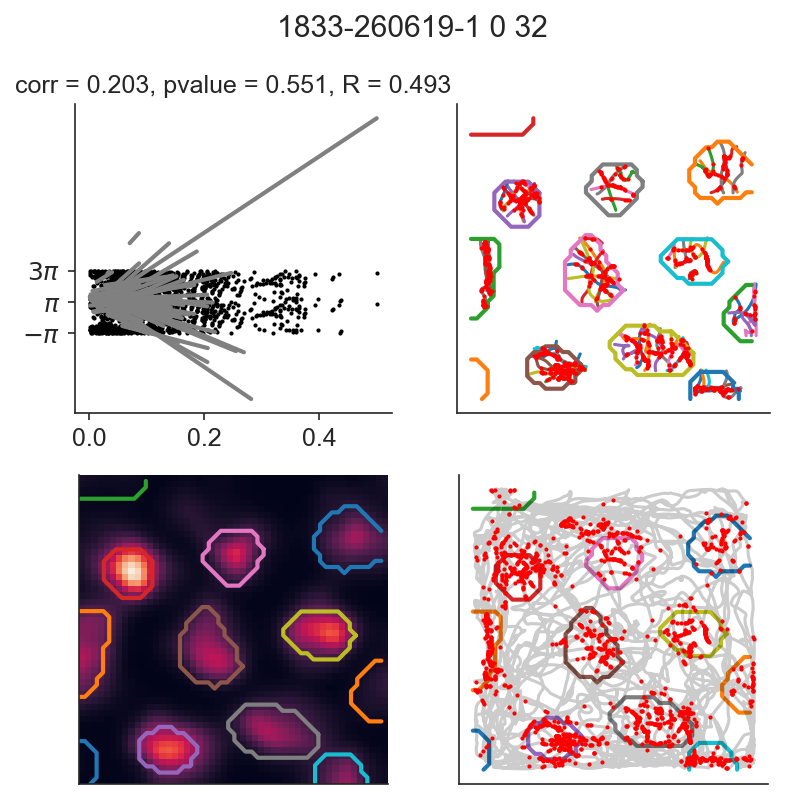

In [31]:
res = compute_phase_precession_runs(
#      data.query('action=="1833-020719-1" and unit_idnum==57').iloc[0], 
    data.query('action=="1833-260619-1" and unit_idnum==32').iloc[0],
     plot='all', save=False, plot_regression_line=True, field_num=None, slope_limit_dist=[-20,20], norm=False, store_runs=True, crossing_type='field')
res = pd.DataFrame(res)
res

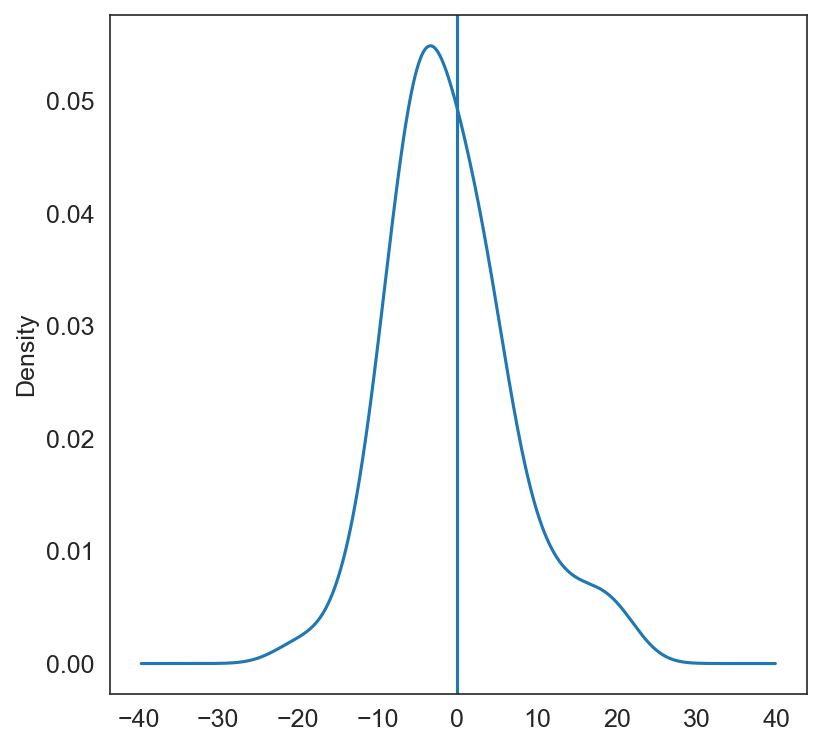

In [32]:
res.slope_dist.plot.density()
# res.slope_dist.hist()
plt.axvline(0)

In [151]:
def compute_phase_precession(row, flim=[6, 10], field_num=None, slope_limit_dist=[-1,1], slope_limit_dur=[-1,1], norm=True, store_runs=False,
                             plot=False, plot_regression_line=True, save=False, dot_size=1, crossing_type='field', plot_title=True, plot_kw={}):
    '''
    flim : [flow, fhigh]
    field_num : int
        which field to plot
    reg_limit : [low, high]
        Regression intervall
    plot : str
        "all" or "scatter"
    plot_regression_line : bool
        plot the regression line in scatter
    save : bool
        save plot
    dot_size : size of scatter dots
    '''
    spike_phase_func, spikes, pos_x, pos_y, pos_t, rate_map, fields = compute_data(row, flim)
    
    if field_num is not None:
        fields = np.where(fields == field_num, fields, 0)
        
        
    if crossing_type == 'field':
        in_field_indices = which_field(pos_x, pos_y, fields, box_size)
        in_field_enter, in_field_exit = compute_crossings(in_field_indices)
    elif crossing_type == 'rate':
        _, _, in_field_enter, in_field_exit = compute_rate_crossings(spikes, pos_t)

    if plot == 'all':
        fig, axs = plt.subplots(2, 2)
        plt.suptitle(f'{row.action} {row.channel_group} {row.unit_idnum}')
    elif plot == 'manus':
        fig, axs = plt.subplots(1, 2)
        axs = [axs]
        axs[0][0].set_ylabel(f'#{row.entity} Unit {row.unit_idnum}')
        axs[0][0].set_title(f'{row.max_rate:.1f} g {row.gridness:.2f}')
    elif plot == 'scatter':
        fig, ax = plt.subplots(1, 1)
        axs = [[ax]]
        ax.set_title(f'{row.action} {row.channel_group} {row.unit_idnum}')

    in_field_spikes, in_field_dur, in_field_dist, spike_phase = [], [], [], []

    sx, sy = interp1d(pos_t, pos_x), interp1d(pos_t, pos_y)
    results = []
    for en, ex in zip(in_field_enter, in_field_exit):
        x, y, t = pos_x[en:ex+1], pos_y[en:ex+1], pos_t[en:ex+1]
        if len(t) <= 1:
            continue
        s = spikes[(spikes > t[0]) & (spikes < t[-1])]
        if len(s) < 5:
            continue

        in_field_spikes.append(s)
        
        dist = distance(x, y)
        if norm:
            t_to_dist = interp1d(t, normalize(dist))
        else:
            t_to_dist = interp1d(t, dist)
        in_field_dist.append(t_to_dist(s))
        
        if norm:
            t_to_dur = interp1d(t, normalize(t))
        else:
            t_to_dur = interp1d(t, t)
        in_field_dur.append(t_to_dur(s))
        
        spike_phase.append(spike_phase_func(s))
        
        if plot == 'all':
            axs[0][1].plot(x, y)
            axs[0][1].scatter(sx(s), sy(s), s=dot_size, color='r', zorder=100000)
            
    dist = np.array([d for di in in_field_dist for d in di])
    dur = np.array([d for di in in_field_dur for d in di])
    phase = np.array([d for di in spike_phase for d in di])
    
    if len(dist) < 2:
        circ_lin_corr_dist, pval_dist, slope_dist, phi0_dist, RR_dist = [np.nan] * 5
        circ_lin_corr_dur, pval_dur, slope_dur, phi0_dur, RR_dur = [np.nan] * 5
    else:
        circ_lin_corr_dist, pval_dist, slope_dist, phi0_dist, RR_dist = cl_corr(
            dist, phase, *slope_limit_dist, return_pval=True)
        circ_lin_corr_dur, pval_dur, slope_dur, phi0_dur, RR_dur = cl_corr(
            dur, phase, *slope_limit_dur, return_pval=True)
    
    results = {
        'action': row.action, 
        'channel_group': row.channel_group, 
        'unit_name': row.unit_name,
        'group': row.group,
        'unit_idnum': row.unit_idnum,
        'flim': flim,
        'slope_limit_dist': slope_limit_dist,
        'slope_limit_dur': slope_limit_dur,
        'crossing_type': crossing_type,
        'norm': norm,
        'circ_lin_corr_dist': circ_lin_corr_dist, 
        'pval_dist': pval_dist, 
        'slope_dist': slope_dist, 
        'phi0_dist': phi0_dist, 
        'RR_dist': RR_dist,
        'circ_lin_corr_dur': circ_lin_corr_dur, 
        'pval_dur': pval_dur, 
        'slope_dur': slope_dur, 
        'phi0_dur': phi0_dur, 
        'RR_dur': RR_dur
    }
    if store_runs:
        results.update({
            'dist': dist,
            'dur': dur,
            'phase': phase
        })
    if plot == 'scatter':
        plot_spike_phase(dist, phase, dot_size, slope_dist, phi0_dist, circ_lin_corr_dist, pval_dist, RR_dist, plot_regression_line, axs[0][0], plot_title)
    if plot == 'all':
        plot_spike_phase(dist, phase, dot_size, slope_dist, phi0_dist, circ_lin_corr_dist, pval_dist, RR_dist, plot_regression_line, axs[0][0], plot_title)
        plot_spikes_and_rate_map(row, rate_map, fields, pos_x, pos_y, sy, sx, spikes, box_size, bin_size, dot_size, flim, output_path, save, axs)
        if plot_title:
            axs[0][0].set_title(
                f'corr = {circ_lin_corr:.3f}, '
                f'pvalue = {pval:.2e}, '
                f'R = {RR:.3f}')
    if plot == 'manus':
        plot_spike_phase(dist, phase, dot_size, slope_dist, phi0_dist, circ_lin_corr_dist, pval_dist, RR_dist, plot_regression_line, axs[0][1], plot_title)
        
        axs[0][0].imshow(rate_map.T, extent=[0, box_size[0], 0, box_size[1]], origin='lower', vmin=plot_kw['vmin'], vmax=plot_kw['vmax'])

        axs[0][0].axis('image')
        axs[0][0].set_xticks([])
        axs[0][0].set_yticks([])
        
        
        axs[0][1].set_ylabel(f'p value={pval_dist:.2e}', rotation=270, labelpad=10)
        axs[0][1].yaxis.set_label_position("right")
        despine()
        plt.tight_layout()
    if plot and save:
        figname = f'{row.action}_{row.channel_group}_{row.unit_idnum}_f{flim[0]}-{flim[1]}'
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)
    return results

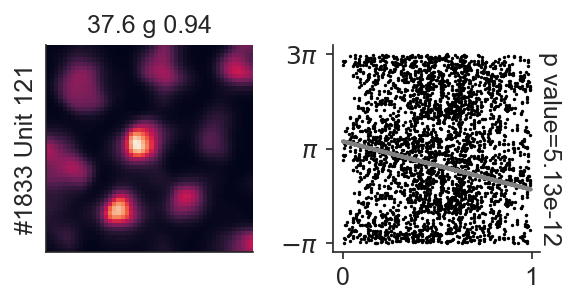

action  channel_group  unit_name       group  unit_idnum     flim  \
0  1833-260619-1              0        132  baseline_i          32  [6, 10]   

  slope_limit_dist slope_limit_dur crossing_type   norm  ...  phi0_dist  \
0        [-20, 20]         [-1, 1]         field  False  ...   3.402985   

    RR_dist  circ_lin_corr_dur  pval_dur  slope_dur  phi0_dur   RR_dur  \
0  0.221042          -0.074469  0.012236  -0.527064  5.392242  0.07193   

                                                dist  \
0  [0.0008336314966839185, 0.04037562373157471, 0...   

                                                 dur  \
0  [22.646533333333334, 22.8028, 22.8194666666666...   

                                               phase  
0  [2.1669906523702367, 2.2734681246321653, 2.983...  

[1 rows x 23 columns]

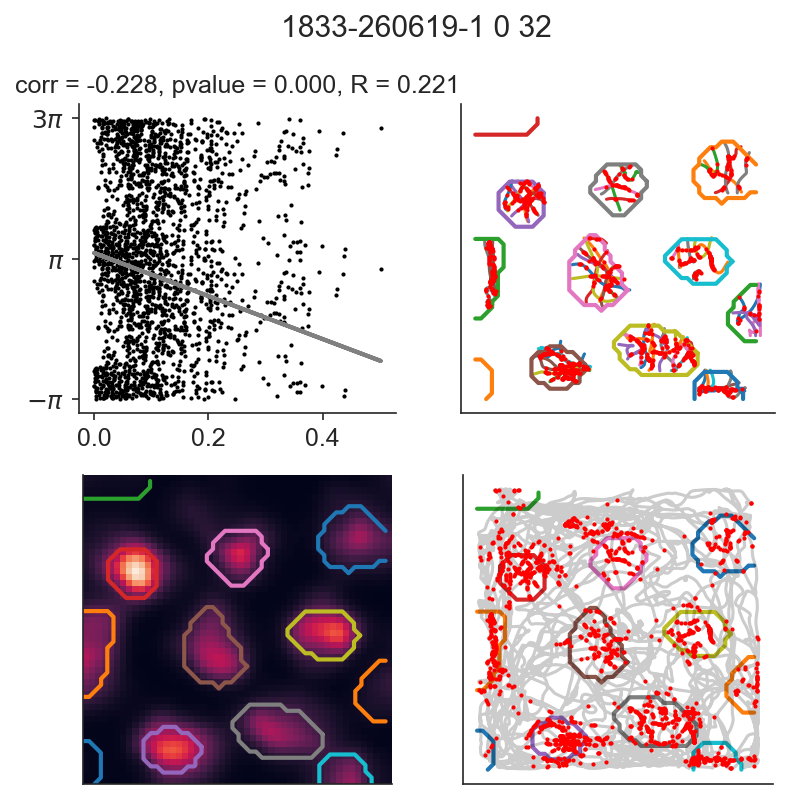

In [34]:
res = compute_phase_precession(
#      data.query('action=="1833-020719-1" and unit_idnum==57').iloc[0], 
     data.query('action=="1833-260619-1" and unit_idnum==32').iloc[0],
     plot='all', save=False, plot_regression_line=True, slope_limit_dist=[-20,20], norm=False, store_runs=True, crossing_type='field')
pd.DataFrame([res])

action  channel_group  unit_name       group  unit_idnum     flim  \
0  1833-260619-1              0        132  baseline_i          32  [6, 10]   

  slope_limit_dist slope_limit_dur crossing_type  norm  ...  phi0_dist  \
0          [-1, 1]         [-1, 1]         field  True  ...    3.87734   

    RR_dist  circ_lin_corr_dur      pval_dur  slope_dur  phi0_dur    RR_dur  \
0  0.251968          -0.196968  5.893841e-11  -0.394581  3.608691  0.226266   

                                                dist  \
0  [0.003130013662070003, 0.15159726377558375, 0....   

                                                 dur  \
0  [0.0030183218156977446, 0.12140216019953652, 0...   

                                               phase  
0  [2.1669906523702367, 2.2734681246321653, 2.983...  

[1 rows x 23 columns]

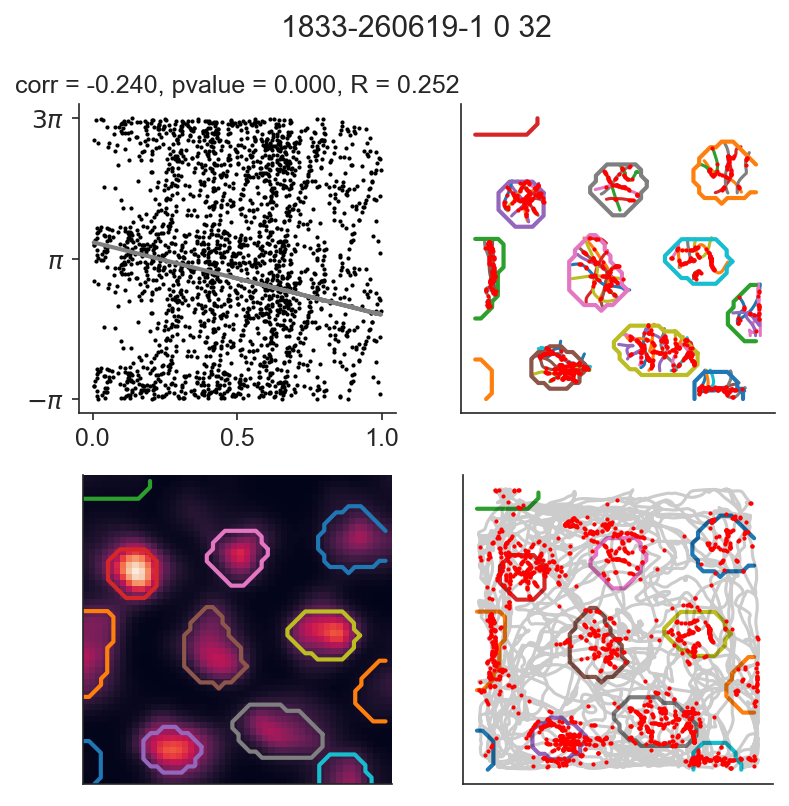

In [35]:
res = compute_phase_precession(
#      data.query('action=="1833-020719-1" and unit_idnum==57').iloc[0], 
     data.query('action=="1833-260619-1" and unit_idnum==32').iloc[0],
     plot='all', save=False, plot_regression_line=True, slope_limit_dist=[-1,1], norm=True, store_runs=True, crossing_type='field')
pd.DataFrame([res])

# Analysis

In [36]:
# results_runs = data.parallel_apply(
#     compute_phase_precession_runs, 
#     axis=1, 
#     slope_limit_dist=[-20, 20], 
#     slope_limit_dur=[-5, 5], 
#     flim=[6,10],
#     norm=False, 
#     store_runs=True, 
#     crossing_type='field'
# )
# results_runs = pd.DataFrame([b for a in results_runs for b in a])

In [44]:
# results_runs_11 = data.parallel_apply(
#     compute_phase_precession, 
#     flim=[10,12], 
#     axis=1, 
#     slope_limit_dist=[-20, 20], 
#     slope_limit_dur=[-5, 5], 
#     norm=False, 
#     store_runs=True, 
#     crossing_type='field'
# )
# results_runs_11 = pd.DataFrame([b for a in results_runs_11 for b in a])

In [45]:
# results_runs_30 = data.parallel_apply(
#     compute_phase_precession, 
#     flim=[29,31], 
#     axis=1, 
#     slope_limit_dist=[-20, 20], 
#     slope_limit_dur=[-5, 5], 
#     norm=False, 
#     store_runs=True, 
#     crossing_type='field'
# )
# results_runs_30 = pd.DataFrame([b for a in results_runs_30 for b in a])

In [46]:
# results_runs = pd.concat([results_runs, results_runs_11, results_runs_30])

In [47]:
# results_runs['flim_str'] = results_runs.apply(lambda x: '_'.join(str(a) for a in x.flim), axis=1)

In [48]:
# plt.scatter(results_runs.circ_lin_corr_dist, results_runs.circ_lin_corr_dur, s=1)

In [49]:
# plt.figure(figsize=(4,4))
# for i, d in results_runs.groupby('group'):
#     s = d.query('flim_str=="6_10"').slope_dist
#     s.plot.density(label=i)
# #     s.hist(label=i, bins=50, histtype='step')
    

# # results_runs.query('flim_str=="10_12"').slope_dist.plot.density(label='f10-12')
# # results_runs.query('flim_str=="29_31"').slope_dist.plot.density(label='f29-31')    

# plt.axvline(0, c='grey', lw=1)
# # plt.xlim(-60,60)
    
# plt.legend()

In [50]:
# plt.figure(figsize=(4,4))
# for i, d in results_runs.groupby('group'):
# #     q_sig = 'pval_dist < 0.01 and RR_dist > .1'
# #     q_sig = 'RR_dist > .1'
#     q_sig = ''
#     q = 'flim_str=="6_10"'
# #     q = 'flim_str=="6_10"'
#     s = d.query(q + q_sig).circ_lin_corr_dist
#     s.plot.density(label=i)
# #     s.hist(label=i, bins=50, histtype='step')
# # results_runs.query('flim_str=="10_12"' + q_sig).circ_lin_corr_dist.plot.density(label='f10-12')
# # results_runs.query('flim_str=="29_31"' + q_sig).circ_lin_corr_dist.plot.density(label='f29-31')

# plt.axvline(0, c='grey', lw=1)
# plt.xlim(-1,1)
# plt.legend()

# Aggregated runs

In [153]:
results_norm = data.parallel_apply(
    compute_phase_precession, 
    axis=1, 
    result_type='expand', 
    slope_limit_dist=[-2, 2], 
    slope_limit_dur=[-2, 2], 
    crossing_type='field',
    store_runs=False,
    norm=True
)

Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-10:
Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-2:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/proc

KeyboardInterrupt: 

KeyboardInterrupt


In [ ]:
results = data.parallel_apply(
    compute_phase_precession, 
    axis=1, 
    result_type='expand', 
    slope_limit_dist=[-20, 20], 
    slope_limit_dur=[-5, 5], 
    crossing_type='field',
    store_runs=False,
    norm=False
)

In [ ]:
# results_11 = data.parallel_apply(
#     compute_phase_precession, 
#     return_runs=False, 
#     flim=[10,12], 
#     axis=1, 
#     result_type='expand',
#     slope_limit_dist=[-2, 2], 
#     slope_limit_dur=[-2, 2], 
#     crossing_type='field'
# )

In [ ]:
# results_30 = data.parallel_apply(
#     compute_phase_precession, 
#     return_runs=False, 
#     flim=[29,31], 
#     axis=1, 
#     result_type='expand',
#     slope_limit_dist=[-2, 2], 
#     slope_limit_dur=[-2, 2], 
#     crossing_type='field'
# )

In [ ]:
# results = pd.concat([results, results_11, results_30])
results = pd.concat([results, results_norm])

In [ ]:
results['flim_str'] = results.apply(lambda x: '_'.join(str(a) for a in x.flim), axis=1)

In [ ]:
# results.to_csv(output_path / 'statistics' / 'results_only_gridcells_above_threshold.csv')

results = pd.read_csv(output_path / 'statistics' / 'results.csv')

In [ ]:
plt.figure(figsize=(4,4))
for i, d in results.groupby(('group', 'norm')):
    q_sig = ' and pval_dist < 0.01 and RR_dist > .1'
#     q_sig = ''
    q = 'flim_str=="6_10"' + q_sig
    if len(d.query(q)) < 2:
        print(i, 'empty')
        continue
    d.query(q).slope_dist.plot.density(label=i)
#     d.query(q).circ_lin_corr_dist.hist(label=i, bins=50, histtype='step')

# results.query('flim_str=="10_12"').slope_dist.plot.density(label='f10-12')
# results.query('flim_str=="29_31"').slope_dist.plot.density(label='f29-31')

plt.axvline(0, c='grey', lw=1)
# plt.xlim(-2,2)
plt.legend()

In [ ]:
# results['entity'] = results.apply(lambda x: x.action.split('-')[0], axis=1)

In [ ]:
plt.figure(figsize=(4,4))

q_sig = ' and pval_dist < 0.01 and RR_dist > .1'
q = 'flim_str=="6_10" and group in ["baseline_i", "baseline_ii"]' + q_sig

s = results.query(q).circ_lin_corr_dist
s.plot.density(label='baseline')

plt.axvline(0, c='grey', lw=1)
plt.xlim(-.5,.5)
plt.legend()

In [ ]:
plt.figure(figsize=(4,4))
# for i, d in results.groupby(('group', 'entity')):
for i, d in results.groupby('group'):
#     if i[0] != 'baseline_i':
#         continue
    q_sig = ' and pval_dist < 0.01 and RR_dist > .1'
    q = 'flim_str=="6_10"' + q_sig
    if len(d.query(q)) < 2:
        print(i, 'empty')
        continue
    s = d.query(q).circ_lin_corr_dist
#     try:
    s.plot.density(label=i)
#         s.hist(label=i, bins=50, histtype='step')
#     except:
#         pass

# results.query('flim_str=="10_12"').circ_lin_corr_dist.plot.density(label='f10-12')
# results.query('flim_str=="29_31"').circ_lin_corr_dist.plot.density(label='f29-31')

plt.axvline(0, c='grey', lw=1)
plt.xlim(-.5,.5)
plt.legend()

In [ ]:
# results.reset_index(drop=True).to_feather(output_path / 'results.feather')

# scatter plot

In [ ]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (2, 2), 
    'figure.dpi': 150,
    'font.size': 12,
})
fig = plt.figure()
palette = sns.color_palette(['#1b9e77','#d95f02','#7570b3','#e7298a'])
sns.set_palette(palette)
sns.swarmplot(
    x="group", 
    y="pval_dist", 
    data=results.query('flim_str=="6_10" and norm and circ_lin_corr_dist < 0'), 
    order=['baseline_i', 'stim_11', 'baseline_ii', 'stim_30']
)
sns.despine()
plt.ylim(-.01,.1)
plt.axhline(0.01, color='k', label='p = 0.01')
plt.xlabel('')
plt.ylabel('p value')
plt.xticks(range(4), ['Baseline I', '11 Hz', 'Baseline II', '30 Hz'], rotation=45)
# plt.legend(frameon=False)

number_of_cells = {}
for i, d in results.query(q).groupby('group'):
    number_of_cells[i] = len(d)
    
for i, k in enumerate(['baseline_i', 'stim_11', 'baseline_ii', 'stim_30']):
    t = f'n = {number_of_cells[k]}' if i==0 else f'{number_of_cells[k]}'
    plt.text(i, .11, t, horizontalalignment='center')
    
figname = f'phase-precession-quantification-swarm'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# barplot

In [ ]:
q_sig = 'pval_dist < 0.01'# and RR_dist > .1'
q = 'flim_str=="6_10" and norm'

percentages = {}
for i, d in results.query(q).groupby('group'):
    percentages[i] = {
        'precess': sum(d.query(q_sig).circ_lin_corr_dist < 0),# / len(d) * 100,
        'recess': sum(d.query(q_sig).circ_lin_corr_dist > 0),# / len(d) * 100,
        'n': len(d)
    }

In [ ]:
percentages

In [ ]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3, 3), 
    'figure.dpi': 150,
    'font.size': 10,
})

fig = plt.figure()
sns.barplot(data=[
    [percentages['baseline_i']['precess']], 
    [percentages['baseline_i']['recess']],
    [percentages['stim_11']['precess']], 
    [percentages['stim_11']['recess']],
    [percentages['baseline_ii']['precess']], 
    [percentages['baseline_ii']['recess']],
    [percentages['stim_30']['precess']], 
    [percentages['stim_30']['recess']],
], color='k')
plt.xticks(
    range(8),
    [
        'Baseline I precession', 
        'Baseline I recession', 
        '11 Hz precession',
        '11 Hz recession',
        'Baseline II precession', 
        'Baseline II recession', 
        '30 Hz precession',
        '30 Hz recession'
    ], rotation=90)
plt.ylabel('Percentage')

_y = 20
plt.text(0, _y, f'n = {percentages["baseline_i"]["n"]}')
plt.text(2, _y, f'n = {percentages["stim_11"]["n"]}')
plt.text(4, _y, f'n = {percentages["baseline_ii"]["n"]}')
plt.text(6, _y, f'n = {percentages["stim_30"]["n"]}')
despine()
figname = f'phase-precession-quantification'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# evaluate single cells

In [140]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (4, 4), 
    'figure.dpi': 150
})

In [27]:
# plt.rc('axes', titlesize=12)
# plt.rcParams.update({
#     'font.size': 12, 
#     'figure.figsize': (6, 6), 
#     'figure.dpi': 150
# })

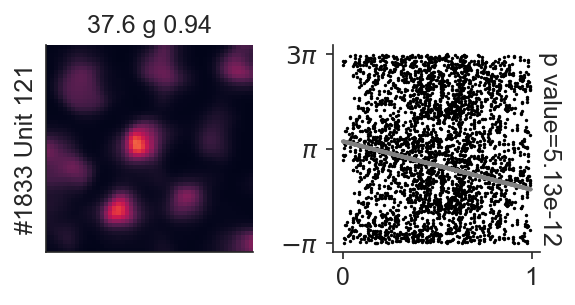

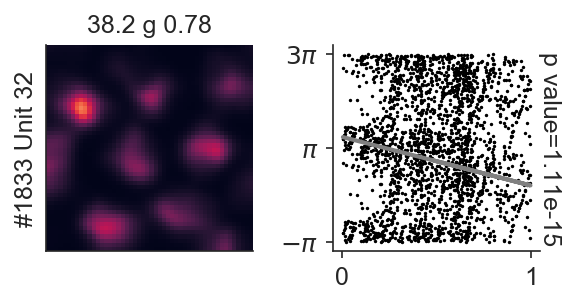

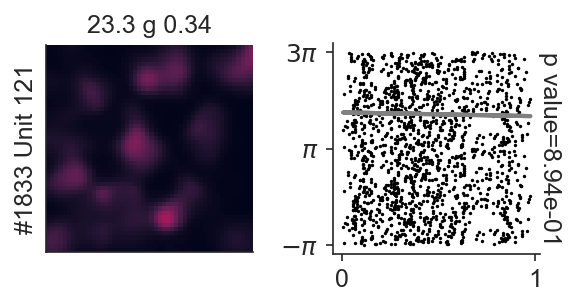

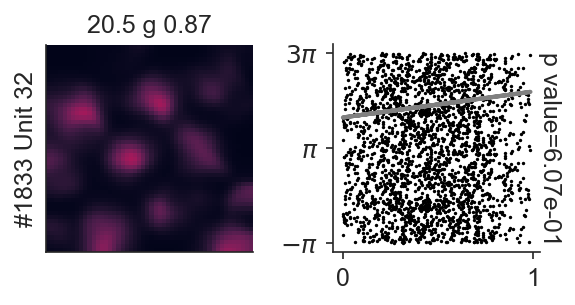

In [152]:
plot_type='manus'
dot_size=.4
compute_phase_precession(
     data.query('action=="1833-010719-1" and unit_idnum==121').iloc[0], 
     plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=True, plot_kw={'vmin':0, 'vmax': 40});
# compute_phase_precession(
#      data.query('action=="1833-120619-1" and unit_idnum==168').iloc[0], 
#      plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=True)
compute_phase_precession(
     data.query('action=="1833-260619-1" and unit_idnum==32').iloc[0], 
     plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=True, plot_kw={'vmin':0, 'vmax': 40})
compute_phase_precession(
     data.query('action=="1833-010719-2" and unit_idnum==121').iloc[0], 
     plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=True, plot_kw={'vmin':0, 'vmax': 40})
# compute_phase_precession(
#      data.query('action=="1833-120619-2" and unit_idnum==168').iloc[0], 
#      plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=False)
compute_phase_precession(
     data.query('action=="1833-260619-2" and unit_idnum==32').iloc[0], 
     plot=plot_type, save=True, plot_regression_line=True, dot_size=dot_size, plot_title=True, plot_kw={'vmin':0, 'vmax': 40});

In [52]:
%debug

> <ipython-input-33-ac7a7b7b3d02>(112)compute_phase_precession()
    110         })
    111     if plot:
--> 112         plot_spike_phase(dist, phase, dot_size, slope_dist, phi0_dist, circ_lin_corr_dist, pval_dist, RR_dist, plot_regression_line, axs[0][0], plot_title)
    113     if plot == 'all':
    114         plot_spikes_and_rate_map(row, rate_map, fields, pos_x, pos_y, sy, sx, spikes, box_size, bin_size, dot_size, flim, output_path, save, axs)



ipdb>  plot


'manus'


ipdb>  axs


*** NameError: name 'axs' is not defined


ipdb>  fig


*** NameError: name 'fig' is not defined


ipdb>  data.action[0]


'1849-060319-3'


ipdb>  data.action


0       1849-060319-3
1       1849-060319-3
2       1849-060319-3
3       1849-060319-3
4       1849-060319-3
            ...      
1279    1833-010719-2
1280    1833-010719-2
1281    1833-010719-2
1282    1833-010719-2
1283    1833-010719-2
Name: action, Length: 1284, dtype: object


ipdb>  row


action                 1833-010719-1
baseline                        True
entity                          1833
frequency                        NaN
i                               True
                      ...           
label_num                          0
query        baseline and i and Hz11
color                        #1b9e77
cell_type                   gridcell
group                     baseline_i
Name: 134, Length: 69, dtype: object


ipdb>  exit


In [48]:

plot_type='manus'
dot_size=.5

compute_phase_precession(
     data.query('action=="1833-010719-2" and unit_idnum==121').iloc[0], 
     plot=plot_type, save=True, flim=[10,12], plot_regression_line=True, dot_size=dot_size, plot_title=False)
compute_phase_precession(
     data.query('action=="1833-120619-2" and unit_idnum==168').iloc[0], 
     plot=plot_type, save=True, flim=[10,12], plot_regression_line=True, dot_size=dot_size, plot_title=False)
compute_phase_precession(
     data.query('action=="1833-260619-2" and unit_idnum==32').iloc[0], 
     plot=plot_type, save=True, flim=[10,12], plot_regression_line=True, dot_size=dot_size, plot_title=False);

UnboundLocalError: local variable 'axs' referenced before assignment

# evaluate all cells

In [113]:
results['session'] = results.apply(lambda x: int(x.action.split('-')[-1]), axis=1)

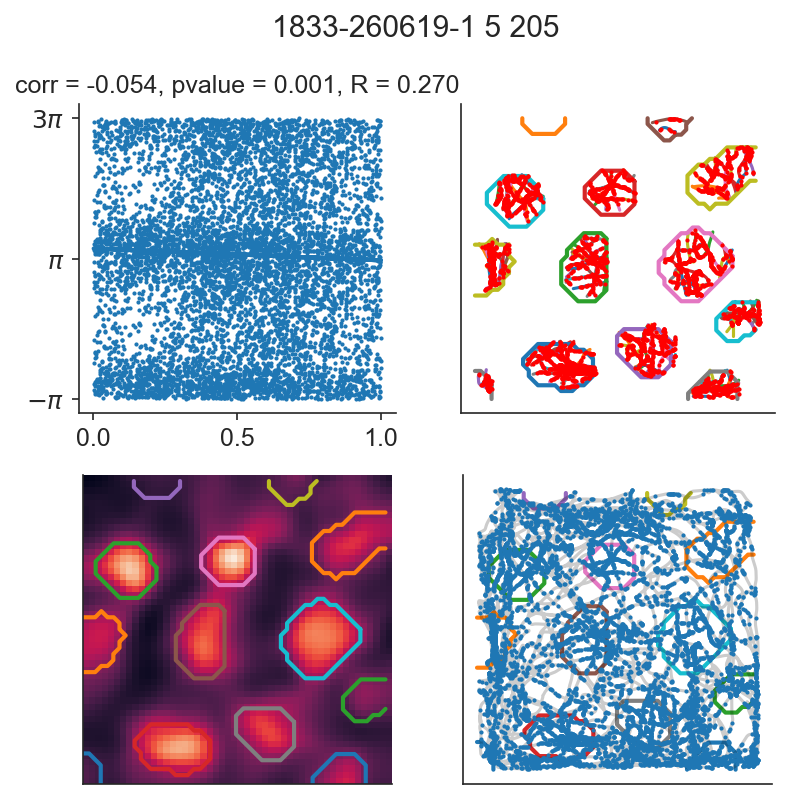

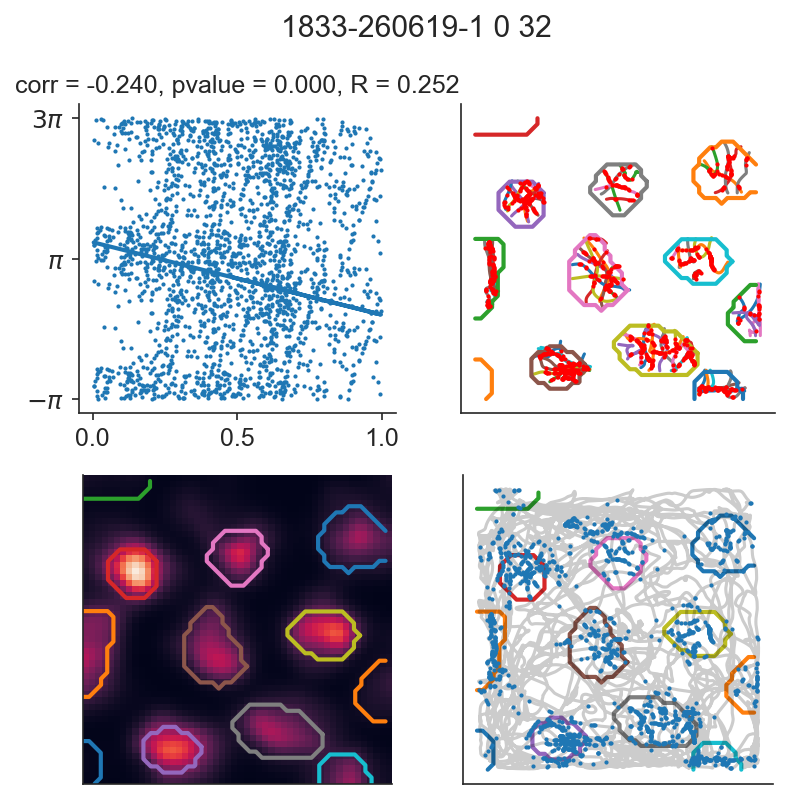

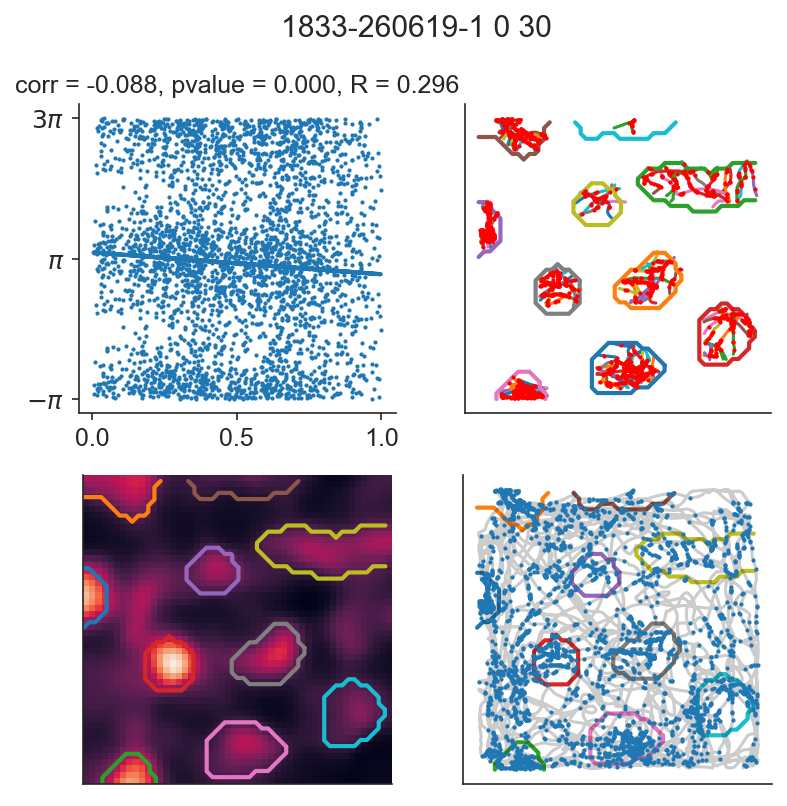

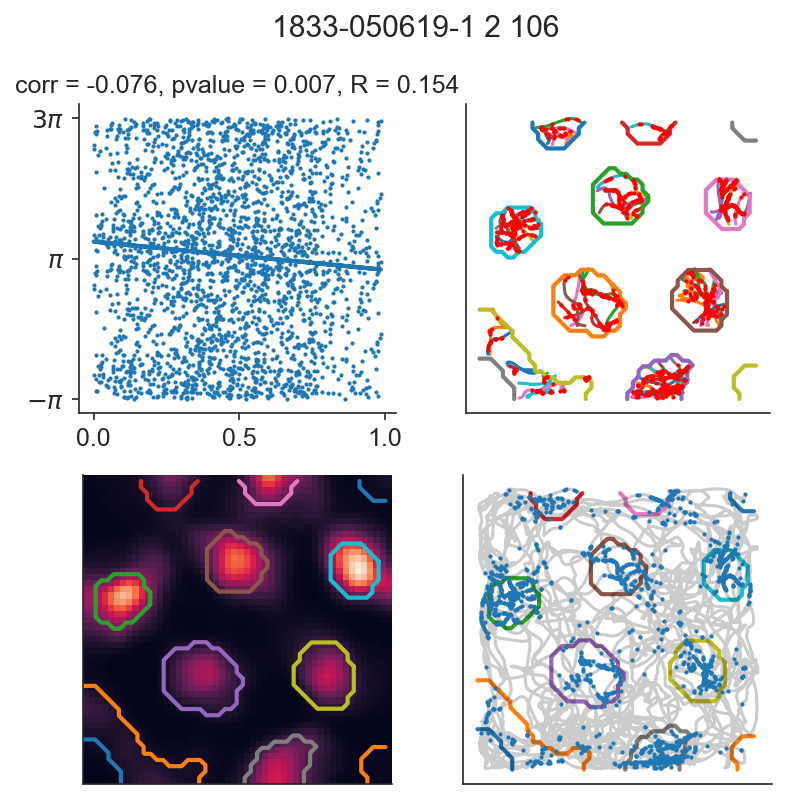

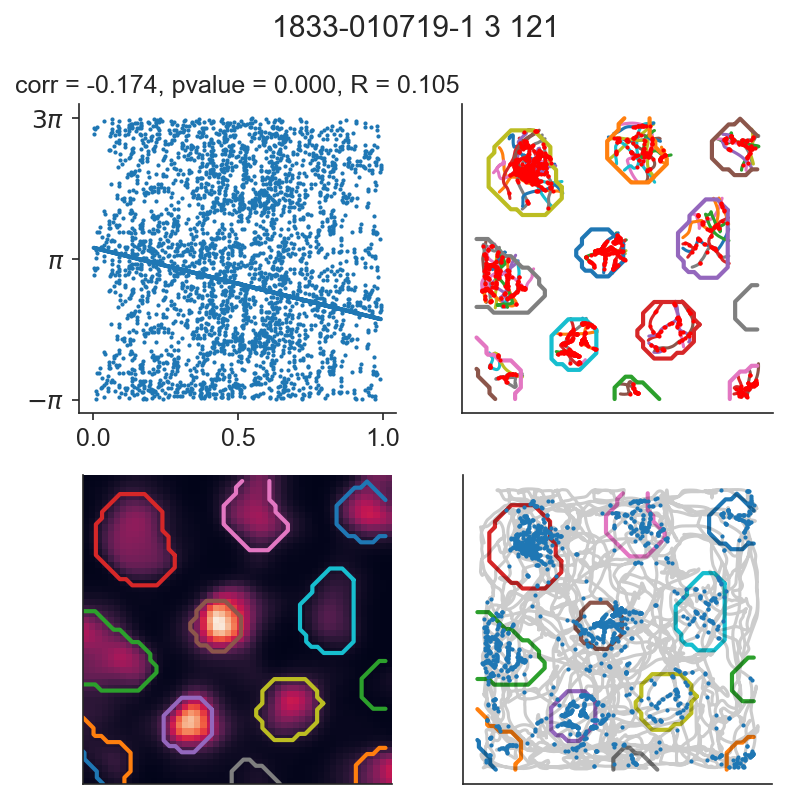

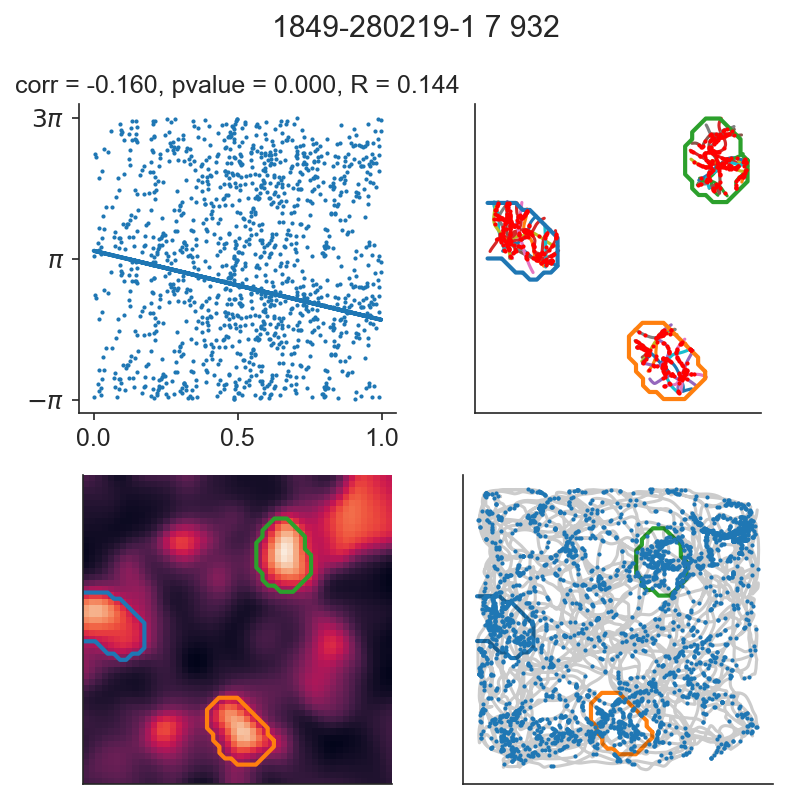

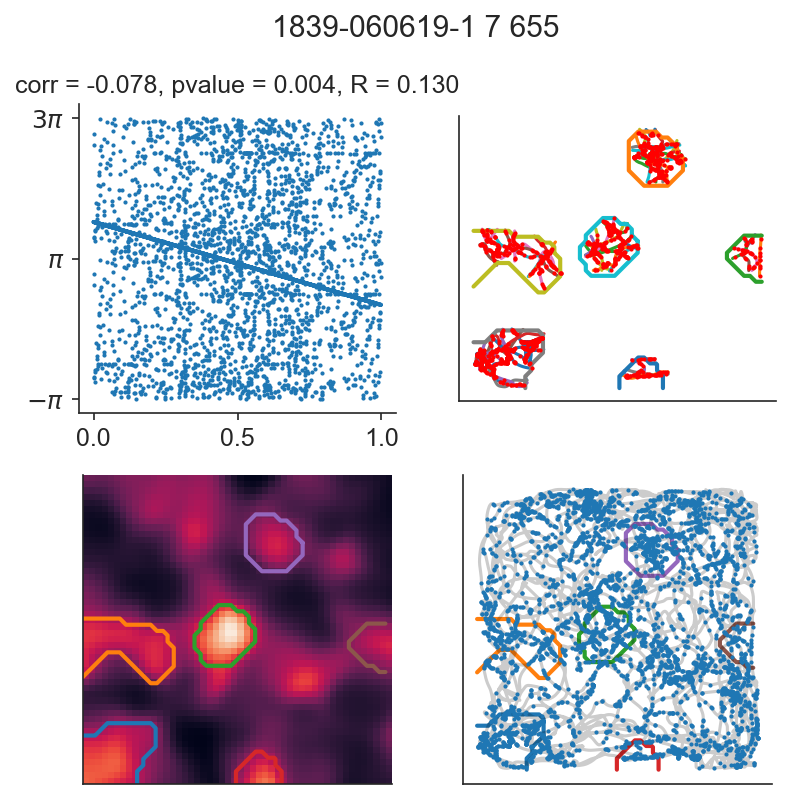

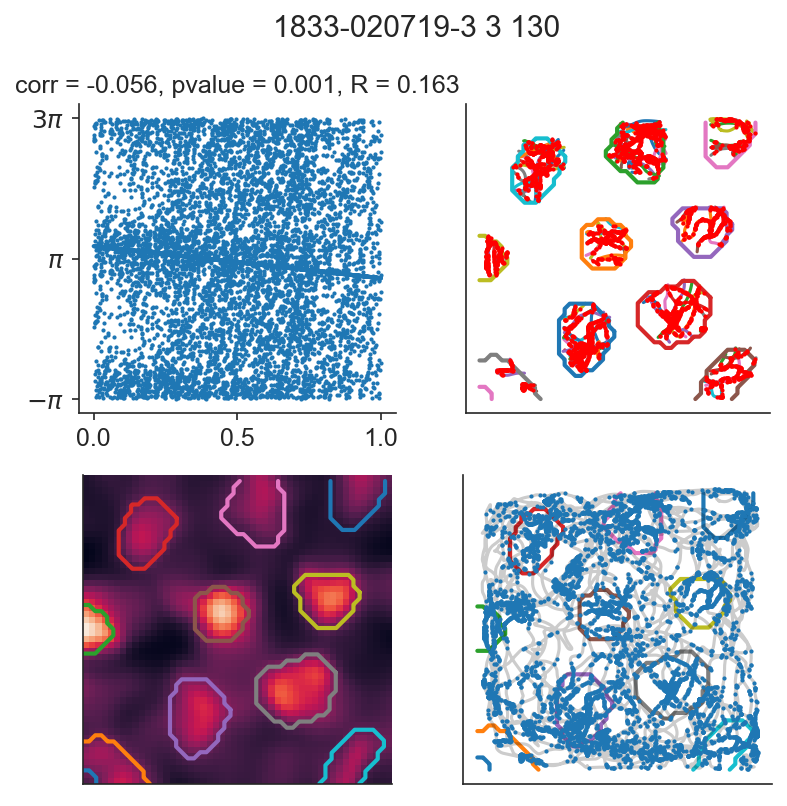

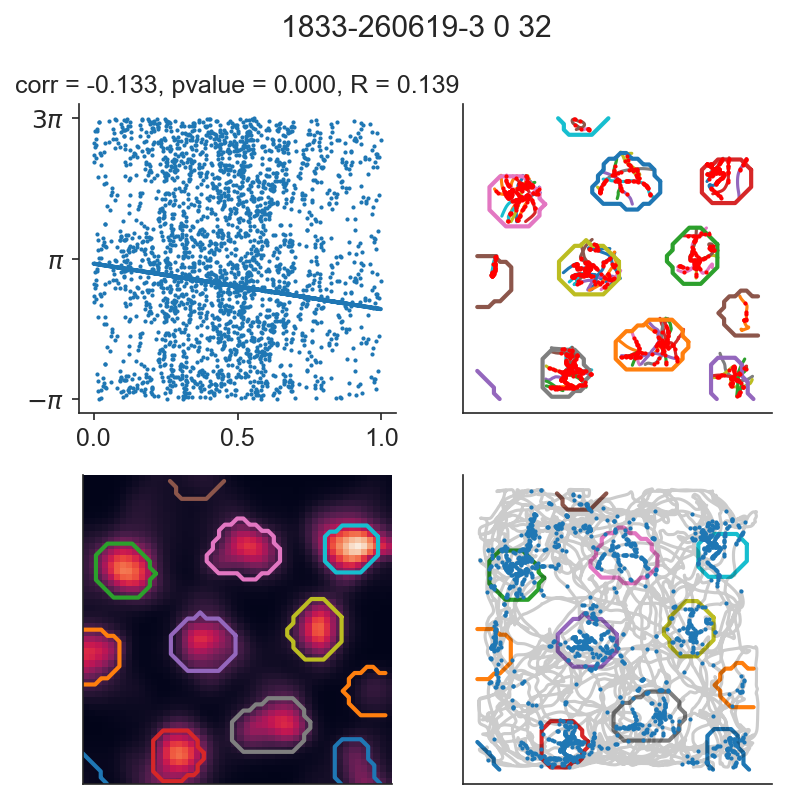

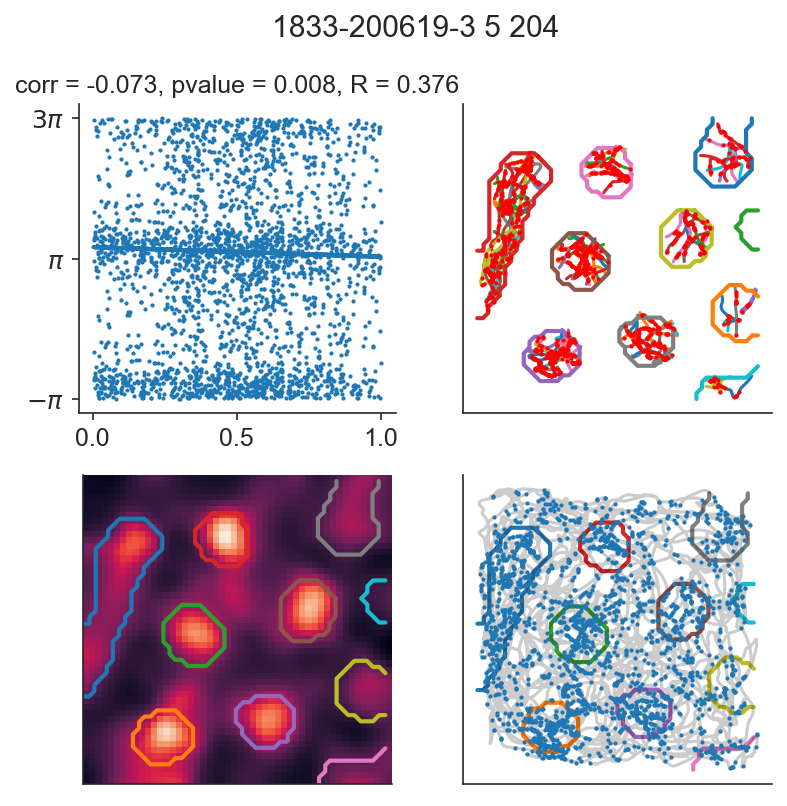

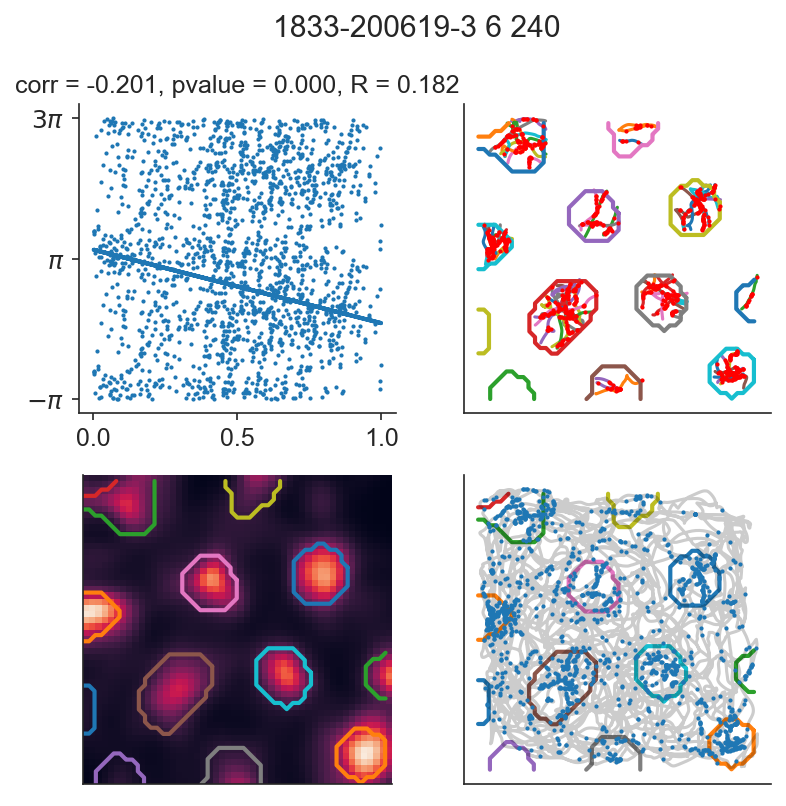

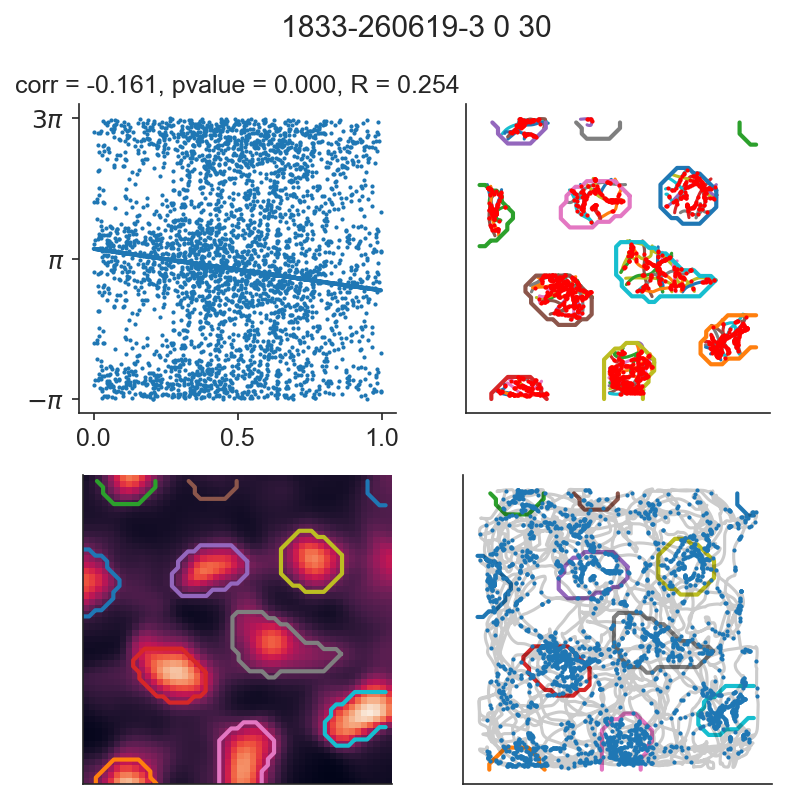

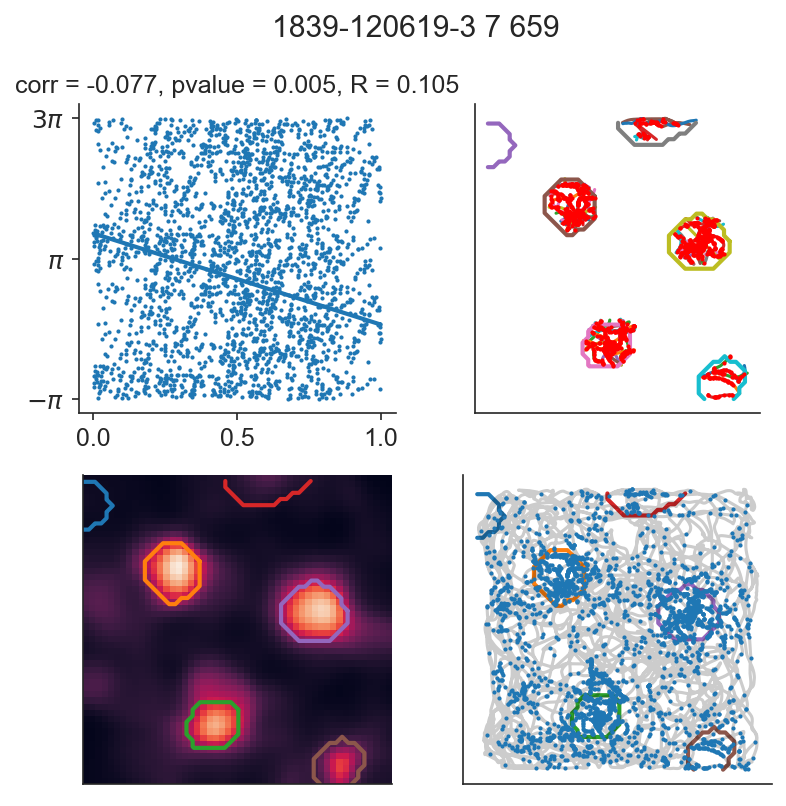

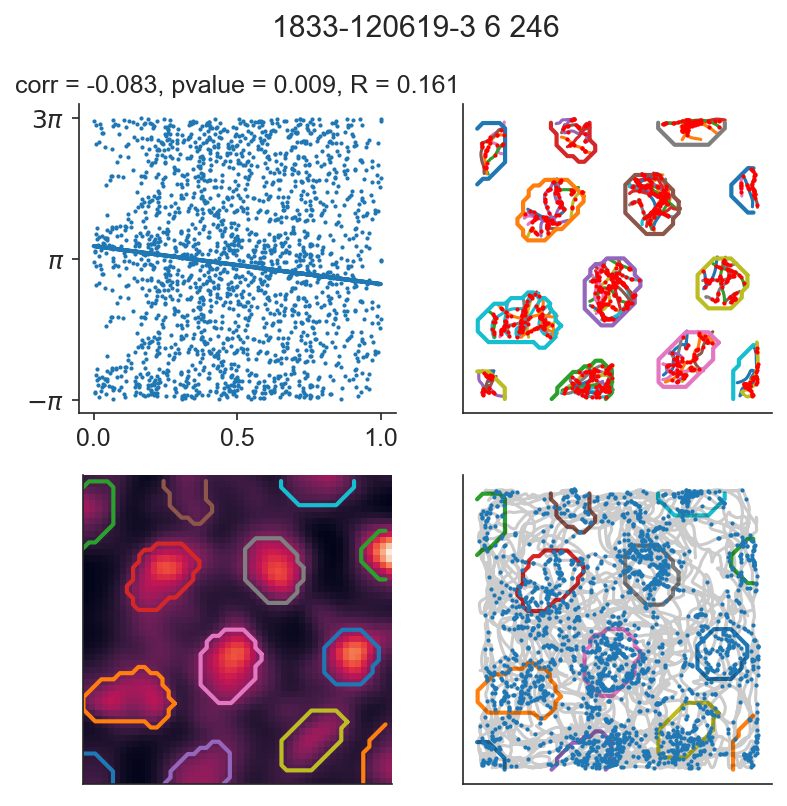

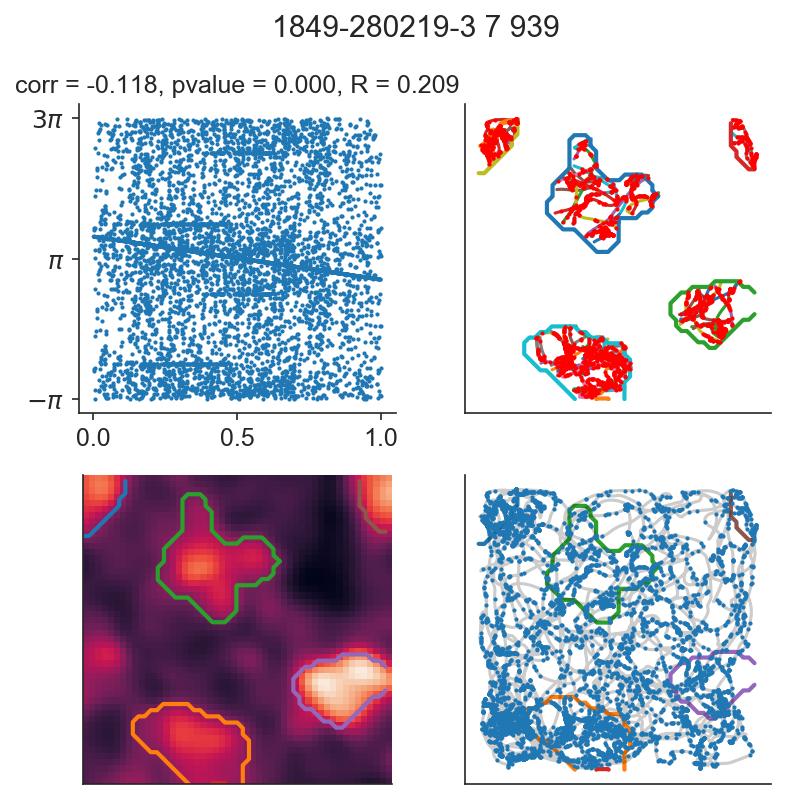

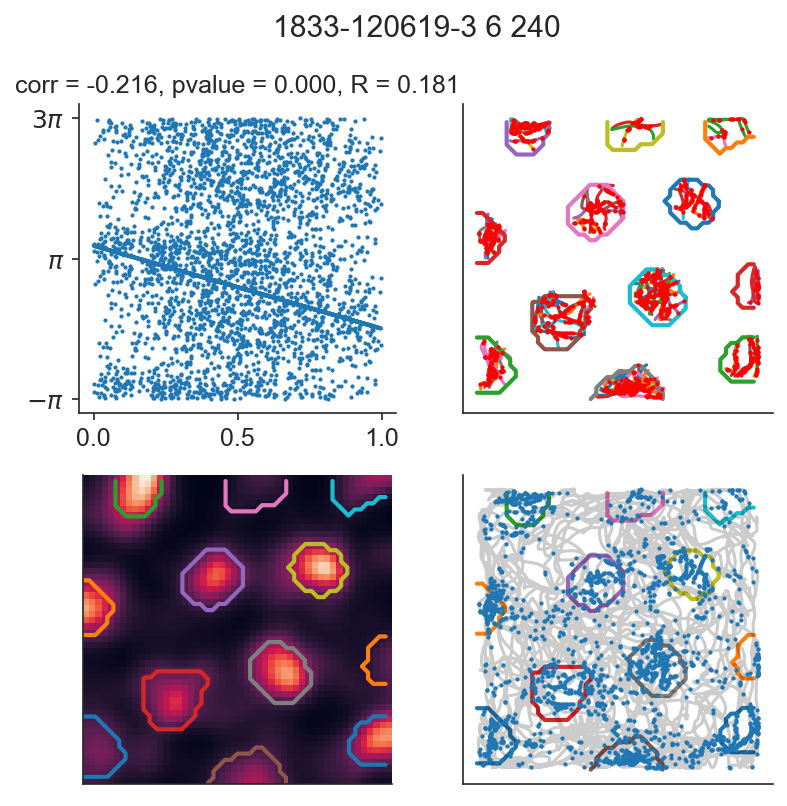

In [130]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 6), 
    'figure.dpi': 150
})

for row in results.sort_values('session').query('pval_dist < 0.01 and RR_dist > .1 and norm and slope_dist < 0').itertuples():
    compute_phase_precession(
        row, plot='all', 
        flim=[6,10], 
        crossing_type='field', 
        dot_size=1, 
        norm=True
    )

# Save to expipe

In [480]:
action = project.require_action("phase-precession")

[autoreload of scipy.stats.stats failed: Traceback (most recent call last):
  File "/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/mikkel/.virtualenvs/expipe/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py", line 180, in <module>
    import scipy.sp

In [481]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/phase-precession/data/results.feather',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-120619-2 4 168.svg',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-260619-2_0_32_f10-12.png',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-260619-2_0_32_f6-10.png',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/phase-precession-quantification.svg',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-010719-1 3 121.svg',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-120619-2_4_168_f10-12.png',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-010719-2 3 121.png',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-120619-2_4_168_f10-12.svg',
 '/media/storage/expipe/septum-mec/actions/phase-precession/data/figures/1833-010719-1 3

In [482]:
septum_mec.analysis.registration.store_notebook(action, "20_phase-precession.ipynb")

# The inverted grid

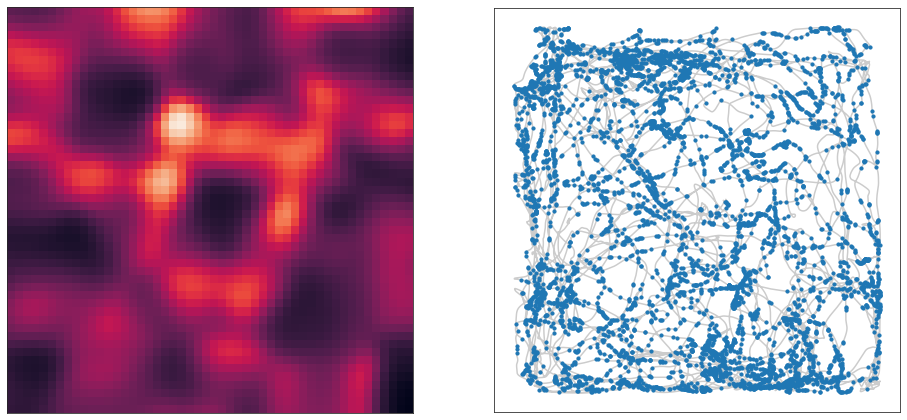

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16,9))
row = baseline_i.sort_values('gridness', ascending=False).iloc[9]
lfp = data_loader.lfp(row.action, row.channel_group)
spikes = data_loader.spike_train(row.action, row.channel_group, row.unit_name)
rate_map = data_loader.rate_map(row.action, row.channel_group, row.unit_name, smoothing=0.04)
pos_x, pos_y, pos_t, pos_speed = map(data_loader.tracking(row.action).get, ['x', 'y', 't', 'v'])
spikes = np.array(spikes)
spikes = spikes[(spikes > pos_t.min()) & (spikes < pos_t.max())]

axs[0].imshow(rate_map.T, extent=[0, box_size[0], 0, box_size[1]], origin='lower')
axs[1].plot(pos_x, pos_y, color='k', alpha=.2, zorder=1000)
axs[1].scatter(interp1d(pos_t, pos_x)(spikes), interp1d(pos_t, pos_y)(spikes), s=10, zorder=10001)

for ax in axs:
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
